In [1]:
import cirq
import numpy as np
# import torch
import sympy
import matplotlib.pyplot as plt
import time
from qsimcirq import QSimSimulator

In [7]:
class DQC(object):
    
    def __init__(self,number_of_qubits,variational_layers,Lambda, kappa):
        self.number_of_qubits=number_of_qubits
        self.variational_layers=variational_layers
        self.encoder_layers = 1
        self.encoder_symbols = []
        self.variational_symbols = []
        self.model_circuit = cirq.Circuit()
        self.qubits = self.initialize_qubits()
        self.full_circuit()
        self.initial_params = np.random.uniform(-np.pi,np.pi, len(self.variational_symbols))
        self.params = self.initial_params.copy()
        self.best_params = self.initial_params.copy()
        self.best_loss = np.inf
        self.losses = []
        self.Lambda = Lambda
        self.kappa = kappa
        self.count = 0
        self.dfdx_list = []
        self.fx_list = []
        self.m_list = []
        self.v_list = []
        np.random.seed(42)
        
        
    def display_circuit(self):
        print(self.model_circuit)
        
    def initialize_qubits(self):
        qubits = [cirq.GridQubit(i, 0) for i in range(self.number_of_qubits)]
        return qubits
    
    def create_encoder_layer(self,dfdx = False,shift = 0, shift_index = 0):
        if dfdx:
            for i in range(self.number_of_qubits):
                x = sympy.Symbol(f'qubit_{i}_dfdx')
                self.encoder_symbols.append(x)
                if i == shift_index:
                    self.model_circuit.append(cirq.ry(((i+1)*sympy.acos(x))+shift).on(self.qubits[i]))
                else:
                    self.model_circuit.append(cirq.ry((i+1)*(sympy.acos(x))).on(self.qubits[i]))
                    
        else:
            for i in range(self.number_of_qubits):
                x = sympy.Symbol(f'qubit_{i}_x')
                self.encoder_symbols.append(x)
                self.model_circuit.append(cirq.ry((i+1)*(sympy.acos(x))).on(self.qubits[i]))
        
    def create_variational_layer(self,layer_number):

        for i in range(self.number_of_qubits):
            self.variational_symbols.append(sympy.Symbol('qubit_'+str(i)+'_theta_z0_' + str(layer_number)))
            self.model_circuit.append(cirq.rz(sympy.Symbol('qubit_'+str(i)+'_theta_z0_' + str(layer_number))).on(self.qubits[i]))
            
            self.variational_symbols.append(sympy.Symbol('qubit_'+str(i)+'_theta_x_' + str(layer_number)))
            self.model_circuit.append(cirq.rx(sympy.Symbol('qubit_'+str(i)+'_theta_x_' + str(layer_number))).on(self.qubits[i]))
            
            self.variational_symbols.append(sympy.Symbol('qubit_'+str(i)+'_theta_z1_' + str(layer_number)))
            self.model_circuit.append(cirq.rz(sympy.Symbol('qubit_'+str(i)+'_theta_z1_' + str(layer_number))).on(self.qubits[i]))
        for i in range(1, self.number_of_qubits):
            self.model_circuit.append(cirq.CNOT(self.qubits[i - 1], self.qubits[i]))

        
    def create_variational_circuit(self):
        for i in range(self.variational_layers):
            self.create_variational_layer(i)

    def create_cost_operator(self):
        for i in range(self.number_of_qubits):
            self.model_circuit.append(cirq.measure(self.qubits[i], key = f'm_{i}'))
    
    def full_circuit(self,dfdx = False,shift = 0, shift_index = 0):
        if dfdx:
            self.model_circuit = cirq.Circuit()
            self.qubits = self.initialize_qubits()
            self.encoder_symbols = []
            self.variational_symbols = []
            self.create_encoder_layer(dfdx = True,shift = shift, shift_index = shift_index)
            self.create_variational_circuit()
            self.create_cost_operator()
        else:
            self.model_circuit = cirq.Circuit()
            self.qubits = self.initialize_qubits()
            self.encoder_symbols = []
            self.variational_symbols = []
            self.create_encoder_layer()
            self.create_variational_circuit()
            self.create_cost_operator()
        
    def replace_symbols_with_values(self,data,parameter_values):
        parameter_dict = {}

        for i in range(len(self.encoder_symbols)):
            parameter_dict[self.encoder_symbols[i]] = data[i]
        for i in range(len(self.variational_symbols)):
            parameter_dict[self.variational_symbols[i]] = parameter_values[i]

        return parameter_dict
    
    def predict(self,data,parameters = None,dfdx=False,shift=0,shift_index=0):
        self.count += 1
        if parameters is None:
            parameters = self.params.copy()
        # Data should be a list of size of number of qubits
        self.full_circuit(dfdx,shift,shift_index)
        parameter_dict = self.replace_symbols_with_values(data,parameters)
        options = {'use_gpu': True}
        simulator = QSimSimulator(qsim_options=options) 
        result = simulator.run(self.model_circuit, parameter_dict,repetitions=1000)
       
        total_magnetization = 0
        
        # Loop over each qubit
        for i in range(self.number_of_qubits):
            # Get the measurement histogram for the current qubit
            histogram = result.histogram(key=f'm_{i}')
            # Map outcomes to eigenvalues: 0 -> +1, 1 -> -1
            magnetization = sum(count * (1 if outcome == 0 else -1) for outcome, count in histogram.items())/1000
            # Normalize by the number of repetitions
            total_magnetization += magnetization 

        return total_magnetization
        
    def compute_actual_dfdx(self,data):
        # Single data point for u(t)
        data_vector = [data]*self.number_of_qubits
        fx = self.predict(data_vector) + 1 - self.predict([0]*self.number_of_qubits)
        self.fx_list.append(fx)
        return -self.Lambda* fx * (self.kappa + np.tan(self.Lambda*data))
    
    def compute_predicted_dfdx(self,data):
        predicted_dfdx = 0
        c_plus = 0
        c_minus = 0
        shift = np.pi/2
        data_vector = [data]*self.number_of_qubits
        for i in range(self.number_of_qubits):
            # self.full_circuit(dfdx=True,shift = shift, shift_index = i)
            # in parameter_dict replace only the ith data with data+shift 
            output = self.predict(data = data_vector,dfdx=True,shift = shift, shift_index = i)
            c_plus += (i+1)* output
            
        for i in range(self.number_of_qubits):
            # self.full_circuit(dfdx=True,shift = -shift, shift_index = i)
            # in parameter_dict replace only the ith data with data-shift
            # output = self.predict(data_vector)
            output = self.predict(data = data_vector,dfdx=True,shift = -shift, shift_index = i)
            c_minus += (i+1)* output
        
        predicted_dfdx = (1 / 4) * (-1 / np.sqrt(1 - data**2)) *(c_plus - c_minus)
        return predicted_dfdx
    
    def compute_predicted_dfdxdtheta(self,data,parameter_index):
        predicted_dfdx_plus = 0
        c_plus = 0
        c_minus = 0
        shift = np.pi/2
        parameters_plus = self.params.copy()
        parameters_plus[parameter_index] += shift
        data_vector = [data]*self.number_of_qubits
        for i in range(self.number_of_qubits):
            # self.full_circuit(dfdx=True,shift = shift, shift_index = i)
            # in parameter_dict replace only the ith data with data+shift 
            output = self.predict(data=data_vector,parameters = parameters_plus,dfdx=True,shift = shift, shift_index = i)
            c_plus += (i+1)*output
            
        for i in range(self.number_of_qubits):
            # self.full_circuit(dfdx=True,shift = -shift, shift_index = i)
            # in parameter_dict replace only the ith data with data-shift
            # output = self.predict(data_vector,parameters_plus)
            output = self.predict(data=data_vector,parameters = parameters_plus,dfdx=True,shift = -shift, shift_index = i)
            
            c_minus += (i+1)*output
        
        predicted_dfdx_plus = (1 / 4) * (-1 / np.sqrt(1 - data**2)) *(c_plus - c_minus)
        c_plus = 0
        c_minus = 0
        parameters_minus = self.params.copy()
        parameters_minus[parameter_index] -= shift
        for i in range(self.number_of_qubits):
            # self.full_circuit(dfdx=True,shift = shift, shift_index = i)
            # in parameter_dict replace only the ith data with data+shift 
            # output = self.predict(data_vector,parameters_minus)
            output = self.predict(data=data_vector,parameters = parameters_minus,dfdx=True,shift = shift, shift_index = i)
            c_plus += (i+1)*output
            
        for i in range(self.number_of_qubits):
            # self.full_circuit(dfdx=True,shift = -shift, shift_index = i)
            # in parameter_dict replace only the ith data with data-shift
            # output = self.predict(data_vector,parameters_minus)
            output = self.predict(data=data_vector,parameters = parameters_minus,dfdx=True,shift = -shift, shift_index = i)
            c_minus += (i+1)*output
        
        predicted_dfdx_minus = (1 / 4) * (-1 / np.sqrt(1 - data**2)) *(c_plus - c_minus)
        
        predicted_dfdx_dtheta = (predicted_dfdx_plus - predicted_dfdx_minus)/(2)
        return predicted_dfdx_dtheta
    
    def compute_predicted_dfdtheta(self,data,parameter_index):
        shift = np.pi/2
        data_vector = [data]*self.number_of_qubits
        self.full_circuit()
        # in parameter_dict replace only the ith data with data+shift 
        parameters_plus = self.params.copy()
        parameters_plus[parameter_index] += shift
        fplus = self.predict(data_vector,parameters_plus)
        parameters_minus = self.params.copy()
        parameters_minus[parameter_index] -= shift
        fminus = self.predict(data_vector,parameters_minus)
        
        predicted_dfdtheta = (fplus - fminus)/(2)
        return predicted_dfdtheta
    
    def single_data_loss_fn(self,data):
        # Single data point for u(t) -self.Lambda* fx * (self.kappa + np.tan(self.Lambda*data))
        predicted_dfdx = self.compute_predicted_dfdx(data)
        self.dfdx_list.append(predicted_dfdx)
        actual_dfdx = self.compute_actual_dfdx(data)
        # initial_condition_predict = self.compute_predicted_dfdx(0)
        actual_initial_condition = 1
        single_data_loss = (predicted_dfdx - actual_dfdx)**2  #(-df0/dx+df/dx - )(1-f0+fx)
        return single_data_loss

    
    def loss_fn(self,data):
        loss = 0
        for i in range(len(data)):
            # print(data[i])
            loss += self.single_data_loss_fn(data[i])
        loss = loss/len(data)
        return loss
    
    def gradient(self,data_list,index):
        grad = 0
        count = 0

        dfodtheta = self.compute_predicted_dfdtheta(0,index)
        for data in data_list: 
            # print(data)
            data_vector = [data]*self.number_of_qubits
            # dfdx = self.compute_predicted_dfdx(data)
            dfdx = self.dfdx_list[count]
            dfdtheta = self.compute_predicted_dfdtheta(data,index)
            dfdx_dtheta = self.compute_predicted_dfdxdtheta(data,index)
            # df0dx_dtheta = self.compute_predicted_dfdxdtheta(0,index)
            # df0dx = self.compute_actual_dfdx(0)
            # fx = self.predict(data_vector)   fx = self.predict(data_vector) + 1 - self.predict([0]*self.number_of_qubits)
            fx = self.fx_list[count]
            grad+= 2*(dfdx+self.Lambda*fx*(self.kappa + np.tan(self.Lambda*data)))*(dfdx_dtheta+self.Lambda*(self.kappa + np.tan(self.Lambda*data)) *(dfdtheta - dfodtheta) )
            count+=1
        grad = grad/len(data_list)
        return grad

    
    
    
    def train(self, data):
        n_epochs = 100
        learning_rate = 0.01
        start_time = time.time()
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-8
        # print(f"Data:{data}")
        for i in range(len(self.variational_symbols)):
            self.m_list.append(0)
            self.v_list.append(0)
            
        for epoch in range(n_epochs):
            self.count = 0
            self.dfdx_list = []
            self.fx_list = []
            loss = self.loss_fn(data)
            gradient_list = []
            # dfodx = self.compute_predicted_dfdx(0)
            # f0 = self.predict([0]*self.number_of_qubits)
            # fx_list = []
            mtilde_list = []
            vtilde_list = []
            
            total_norm = 0.0
            for i in range(len(self.variational_symbols)):
                gradient_list.append(self.gradient(data,i))
                total_norm+= gradient_list[i]**2
            # print(f"Gradients: {gradient_list}")  
            total_norm = total_norm**0.5
            if total_norm> 1:# max norm is 1
                # print("Clipping happend")
                clip = 1/(total_norm+1e-6)
                for i in range(len(self.variational_symbols)):
                    gradient_list[i] = gradient_list[i]*clip
            # print(f"Gradients clipped:{gradient_list}")
            
            for i in range(len(self.variational_symbols)):
                self.m_list[i] = beta1*self.m_list[i] + (1-beta1)*gradient_list[i]
                mtilde_list.append(self.m_list[i]/(1-(beta1)**(epoch+1)))
                self.v_list[i] = beta2*self.v_list[i] + (1-beta2)*gradient_list[i]**2
                vtilde_list.append(self.v_list[i]/(1-(beta2)**(epoch+1)))
            
            for i in range(len(self.variational_symbols)):
                self.params[i] = self.params[i] - learning_rate * mtilde_list[i]/(np.sqrt(vtilde_list[i])+epsilon)
            
            # for i in range(len(self.variational_symbols)):
            #     self.params[i] = self.params[i] - learning_rate * gradient_list[i]
            
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f} Time: {time.time() - start_time:.2f} s Count: {self.count}")
            self.losses.append(loss)
            if self.losses[-1] < self.best_loss:
                self.best_loss = self.losses[-1]
                self.best_params = self.params.copy()
            # print(f"Data:{data}")
            # print(f"Initial Parameters: {self.initial_params}")
            # print(f"Current Params: {self.params}")
            # print(f"Best Params: {self.best_params}")
            # print(f"Best Loss: {self.best_loss}")
                
    
    
    
        

        
            
            

In [8]:
a = DQC(number_of_qubits=3,variational_layers=3,Lambda=8.0,kappa=0.1)
# (self,number_of_qubits,variational_layers,Lambda, kappa)

In [9]:
a.display_circuit()

(0, 0): ───Ry(acos(qubit_0_x))─────Rz(qubit_0_theta_z0_0)───Rx(qubit_0_theta_x_0)───Rz(qubit_0_theta_z1_0)───@───Rz(qubit_0_theta_z0_1)───Rx(qubit_0_theta_x_1)────Rz(qubit_0_theta_z1_1)────────────────────────────@───Rz(qubit_0_theta_z0_2)───Rx(qubit_0_theta_x_2)────Rz(qubit_0_theta_z1_2)────────────────────────────@───M('m_0')──────────────
                                                                                                             │                                                                                                       │                                                                                                       │
(1, 0): ───Ry(2*acos(qubit_1_x))───Rz(qubit_1_theta_z0_0)───Rx(qubit_1_theta_x_0)───Rz(qubit_1_theta_z1_0)───X───@────────────────────────Rz(qubit_1_theta_z0_1)───Rx(qubit_1_theta_x_1)────Rz(qubit_1_theta_z1_1)───X───@────────────────────────Rz(qubit_1_theta_z0_2)───Rx(qubit_1_theta_x_2)────Rz(qubit_1_theta_z1_2)───X───@──────────M('m_

In [10]:
xmin = 0
xmax = 0.9
data = np.linspace(xmin, xmax, 20)
print(data)

[0.         0.04736842 0.09473684 0.14210526 0.18947368 0.23684211
 0.28421053 0.33157895 0.37894737 0.42631579 0.47368421 0.52105263
 0.56842105 0.61578947 0.66315789 0.71052632 0.75789474 0.80526316
 0.85263158 0.9       ]


In [11]:
a.train(data)

Epoch 1/100, Loss: 1649.1708 Time: 260.25 s Count: 7774
Epoch 2/100, Loss: 1484.5518 Time: 454.72 s Count: 7774
Epoch 3/100, Loss: 1328.0954 Time: 649.36 s Count: 7774
Epoch 4/100, Loss: 1146.8863 Time: 845.92 s Count: 7774
Epoch 5/100, Loss: 1454.3638 Time: 1041.79 s Count: 7774
Epoch 6/100, Loss: 1111.8974 Time: 1237.21 s Count: 7774
Epoch 7/100, Loss: 810.0403 Time: 1433.20 s Count: 7774
Epoch 8/100, Loss: 1277.1176 Time: 1628.80 s Count: 7774
Epoch 9/100, Loss: 684.4979 Time: 1823.58 s Count: 7774
Epoch 10/100, Loss: 911.7756 Time: 2019.06 s Count: 7774
Epoch 11/100, Loss: 803.5375 Time: 2213.92 s Count: 7774
Epoch 12/100, Loss: 580.8306 Time: 2408.99 s Count: 7774
Epoch 13/100, Loss: 789.9766 Time: 2604.47 s Count: 7774
Epoch 14/100, Loss: 723.3919 Time: 2799.57 s Count: 7774
Epoch 15/100, Loss: 770.5407 Time: 2993.68 s Count: 7774
Epoch 16/100, Loss: 619.3973 Time: 3188.60 s Count: 7774
Epoch 17/100, Loss: 385.4084 Time: 3386.36 s Count: 7774
Epoch 18/100, Loss: 564.6183 Time: 35

0.025209426879882812 vs 0.06

In [12]:
def u(x):
    return np.exp(-0.1*8*x)*np.cos(8*x)
    # return 3*x

In [13]:
def f_exact(x):
    return 5*(x**4 + (1/3)*x**3 - x**2 - 0.5*x)

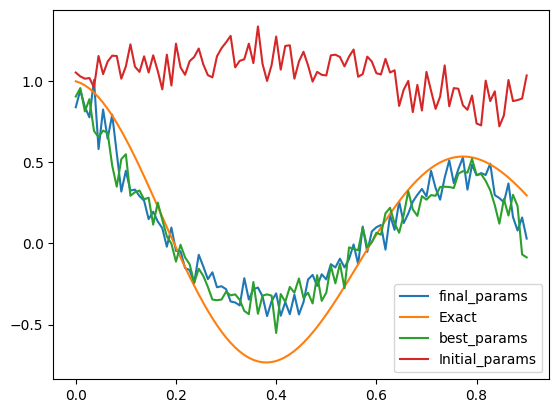

In [14]:
xtest = np.linspace(xmin, xmax, 100)
result_exact = u(xtest)
# result_exact = f_exact(xtest)
result_model_old = []
for i in range(len(xtest)):
    temp = 1-a.predict([0]*a.number_of_qubits,a.params) + a.predict([xtest[i]]*a.number_of_qubits, a.params)
    result_model_old.append(temp)

result_model_old = np.array(result_model_old)
result_model_new = []
for i in range(len(xtest)):
    temp = 1-a.predict([0]*a.number_of_qubits,a.best_params) +a.predict([xtest[i]]*a.number_of_qubits, a.best_params)
    result_model_new.append(temp)

result_model_initial = []
for i in range(len(xtest)):
    temp = 1-a.predict([0]*a.number_of_qubits,a.initial_params) +a.predict([xtest[i]]*a.number_of_qubits, a.initial_params)
    result_model_initial.append(temp)
    
result_model_new = np.array(result_model_new)
plt.plot(xtest, result_model_old, label = "final_params")
plt.plot(xtest, result_exact, label = "Exact")
plt.plot(xtest, result_model_new, label = "best_params")
plt.plot(xtest,result_model_initial, label = "Initial_params")
plt.legend()
plt.show()

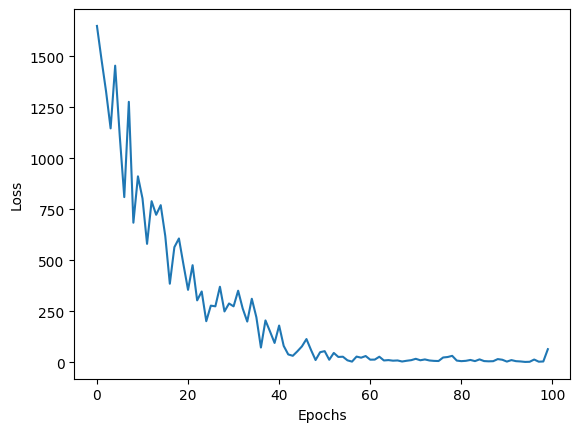

In [15]:
#plot losses versus epochs
epochs = np.arange(0, 100, 1)
losses = []
for i in range(len(a.losses)):
    losses.append(a.losses[i])
plt.plot(epochs, losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.ylim(0, 1)
plt.show()

In [16]:
import pickle

In [17]:
filepath1 = "Outputs/final_params_100_epochs_lambda_8_lr_001 correct float.pickle"
filepath2 = "Outputs/result_model_100_epochs_lambda_8_lr_001 correct float.pickle"
filepath3 = "Outputs/result_actual_100_epochs_lambda_8_lr_001 correct float.pickle"
filepath4 = "Outputs/losses_100_epochs_lambda_8_lr_001 correct float.pickle"

In [18]:
with open(filepath1, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(a.params, file)
    print("Data Stored Successfully")
    
with open(filepath2, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(result_model_old, file)
    print("Data Stored Successfully")
    
with open(filepath3, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(result_exact, file)
    print("Data Stored Successfully")
    
with open(filepath4, 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(a.losses, file)
    print("Data Stored Successfully")

Data Stored Successfully
Data Stored Successfully
Data Stored Successfully
Data Stored Successfully


In [19]:
error = 0
for i in range(len(result_exact)):
    error+= (result_exact[i]-result_model_old[i])**2
error/=len(result_exact)
print(error)

0.04497591903771586
